1632036002 박종섭 (kugipark@gmail.com)

# 독버섯 vs. 식용버섯 - Multi-layer Neural Network으로 구분하기

## 1. Data Set Description

* http://archive.ics.uci.edu/ml/datasets/Mushroom
* Attribute Information
  * 0 - classes (target attribute): edible=e, poisonous=p
  * 1 - cap-shape: bell=b, conical=c, convex=x, flat=f, knobbed=k, sunken=s
  * 2 - cap-surface: fibrous=f, grooves=g, scaly=y, smooth=s
  * 3 - cap-color: brown=n, buff=b, cinnamon=c, gray=g, green=r, pink=p, purple=u, red=e, white=w, yellow=y
  * 4 - bruises: bruises=t, no=f
  * 5 - odor: almond=a, anise=l, creosote=c, fishy=y, foul=f, musty=m, none=n, pungent=p, spicy=s
  * 6 - gill-attachment: attached=a, descending=d, free=f, notched=n
  * 7 - gill-spacing: close=c,crowded=w,distant=d
  * 8 - gill-size: broad=b, narrow=n
  * 9 - gill-color: black=k, brown=n, buff=b, chocolate=h, gray=g, green=r, orange=o, pink=p, purple=u, red=e, white=w, yellow=y
  * 10 - stalk-shape: enlarging=e, tapering=t
  * 11 - stalk-root: bulbous=b, club=c, cup=u, equal=e, rhizomorphs=z, rooted=r, missing=?
  * 12 - stalk-surface-above-ring: fibrous=f, scaly=y, silky=k, smooth=s
  * 13 - stalk-surface-below-ring: fibrous=f, scaly=y, silky=k, smooth=s
  * 14 - stalk-color-above-ring: brown=n, buff=b, cinnamon=c, gray=g, orange=o, pink=p, red=e, white=w, yellow=y
  * 15 - stalk-color-below-ring: brown=n, buff=b, cinnamon=c, gray=g, orange=o, pink=p, red=e, white=w, yellow=y
  * 16 - veil-type: partial=p, universal=u
  * 17 - veil-color: brown=n, orange=o, white=w, yellow=y
  * 18 - ring-number: none=n, one=o, two=t
  * 19 - ring-type: cobwebby=c, evanescent=e, flaring=f, large=l, none=n, pendant=p, sheathing=s, zone=z
  * 20 - spore-print-color: black=k, brown=n, buff=b, chocolate=h, green=r, orange=o, purple=u, white=w, yellow=y
  * 21 - population: abundant=a, clustered=c, numerous=n, scattered=s, several=v, solitary=y
  * 22 - habitat: grasses=g, leaves=l, meadows=m, paths=p, urban=u, waste=w, woods=d

## 2. Pandas DataFame 및 Numpy Array를 사용하여 데이터 준비하기

### 1) Loading Data

In [1]:
import sys
sys.version

'3.5.3 |Continuum Analytics, Inc.| (default, Feb 22 2017, 21:28:42) [MSC v.1900 64 bit (AMD64)]'

* 참고: 다음 모듈이 conda environment에 설치되어 있지 않아서 conda install 명령어를 이용하여 설치함
  * scipy
  * pandas
  * matplotlib

In [2]:
import urllib
from scipy import stats
from pandas import Series, DataFrame
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

path = 'http://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data'
col_names = range(23)

In [3]:
raw_csv = urllib.request.urlopen(path)
df = pd.read_csv(raw_csv, names = col_names)
print(len(df))

8124


In [4]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


### 2) Categorical Attribute를 Numerical Attribute로 변환

In [5]:
num_columns = df.shape[1]
map_dic = {}
for i in range(num_columns):
    unique_array = df[i].unique()
    N = len(unique_array)
    map_dic[i] = {}

    for j in range(N):
        map_dic[i][unique_array[j]] = j

    df[i] = df[i].map(map_dic[i])

In [6]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,1,0,1,0,0,1,0,...,0,0,0,0,0,0,0,1,1,1
2,1,1,0,2,0,2,0,0,1,1,...,0,0,0,0,0,0,0,1,1,2
3,0,0,1,2,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,3,1,3,0,1,1,0,...,0,0,0,0,0,0,1,1,2,1


### 3) 각 컬럼별 Normalization

각 feature 값을 0~1 사이의 값으로 정규화한다.

In [7]:
for i in range(1, num_columns):
    unique_array = df[i].unique()
    N = len(unique_array)
    map_dic_sub = {}

    for j in range(N):
        if j == 0:
            map_dic_sub[j] = 0
        else:
            map_dic_sub[j] = j / float(N - 1)        

    df[i] = df[i].map(map_dic_sub)

In [8]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,0,0.0,0.000000,0.000000,0.0,0.000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0,0.0,0.0,0.00,0.000,0.0,0.000000
1,1,0.0,0.000000,0.111111,0.0,0.125,0.0,0.0,1.0,0.000000,...,0.0,0.0,0.0,0,0.0,0.0,0.00,0.125,0.2,0.166667
2,1,0.2,0.000000,0.222222,0.0,0.250,0.0,0.0,1.0,0.090909,...,0.0,0.0,0.0,0,0.0,0.0,0.00,0.125,0.2,0.333333
3,0,0.0,0.333333,0.222222,0.0,0.000,0.0,0.0,0.0,0.090909,...,0.0,0.0,0.0,0,0.0,0.0,0.00,0.000,0.0,0.000000
4,1,0.0,0.000000,0.333333,1.0,0.375,0.0,1.0,1.0,0.000000,...,0.0,0.0,0.0,0,0.0,0.0,0.25,0.125,0.4,0.166667


### 4) 데이터 전처리 작업

raw데이터의 label과 features를 분리한다.

In [9]:
data_df = df.iloc[:, 1:]

In [10]:
data_df.head()

,1,2,3,4,5,6,7,8,9,10,...,13,14,15,16,17,18,19,20,21,22
0,0.0,0.000000,0.000000,0.0,0.000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0,0.0,0.0,0.00,0.000,0.0,0.000000
1,0.0,0.000000,0.111111,0.0,0.125,0.0,0.0,1.0,0.000000,0.0,...,0.0,0.0,0.0,0,0.0,0.0,0.00,0.125,0.2,0.166667
2,0.2,0.000000,0.222222,0.0,0.250,0.0,0.0,1.0,0.090909,0.0,...,0.0,0.0,0.0,0,0.0,0.0,0.00,0.125,0.2,0.333333
3,0.0,0.333333,0.222222,0.0,0.000,0.0,0.0,0.0,0.090909,0.0,...,0.0,0.0,0.0,0,0.0,0.0,0.00,0.000,0.0,0.000000
4,0.0,0.000000,0.333333,1.0,0.375,0.0,1.0,1.0,0.000000,1.0,...,0.0,0.0,0.0,0,0.0,0.0,0.25,0.125,0.4,0.166667


In [11]:
data_array = data_df.as_matrix()
print(type(data_array), data_array.shape)

<class 'numpy.ndarray'> (8124, 22)


In [12]:
label_df = df.iloc[:, 0:1]

In [13]:
label_df.head()

,0
0,0
1,1
2,1
3,0
4,1


In [14]:
label_array = label_df.as_matrix()
print(type(label_array), label_array.shape)

<class 'numpy.ndarray'> (8124, 1)


In [15]:
label_array_one_hot = []

for i in label_array:
    if i == 0:
        one_hot = [1, 0]

    else:
        one_hot = [0, 1]

    label_array_one_hot.append(one_hot) 

In [16]:
label_array_one_hot =  np.array(label_array_one_hot)
print(type(label_array_one_hot), label_array_one_hot.shape)

<class 'numpy.ndarray'> (8124, 2)


In [17]:
train = {'data': None, 'labels': None}
validation = {'data': None, 'labels': None}
test = {'data': None, 'labels': None}

In [18]:
import random
pick = random.random()
train_data = []
train_labels = []
validation_data = []
validation_labels = []
test_data = []
test_labels = []

for i in range(len(data_array)):
    pick = random.random()

    if pick < 0.80:
        train_data.append(data_array[i])
        train_labels.append(label_array_one_hot[i])

    elif pick >= 0.80 and pick < 0.85:
        validation_data.append(data_array[i])
        validation_labels.append(label_array_one_hot[i])

    elif pick >= 0.85:
        test_data.append(data_array[i])
        test_labels.append(label_array_one_hot[i])
       
train['data'] = np.array(train_data)
train['labels'] = np.array(train_labels)
validation['data'] = np.array(validation_data)
validation['labels'] = np.array(validation_labels)
test['data'] = np.array(test_data)
test['labels'] = np.array(test_labels)

In [19]:
print(train['data'].shape, train['labels'].shape)

(6492, 22) (6492, 2)


In [20]:
print(validation['data'].shape, validation['labels'].shape)

(394, 22) (394, 2)


In [21]:
print(test['data'].shape, test['labels'].shape)

(1238, 22) (1238, 2)


## 3.Multi-layer Neural Network 모델 생성 및 테스트하기

In [22]:
data_df.columns.size

22

In [23]:
import tensorflow as tf
import math

In [24]:
batch_size = 400
training_epochs = 50
learning_rate = 0.05

In [25]:
# Network Parameters

n_input = data_df.columns.size # 22개
n_hidden_1 = 42 # 1st layer number of features
n_hidden_2 = 42 # 2nd layer number of features
n_classes = 2 # Edible / Not Edible

In [26]:
# Data Preparation

x = tf.placeholder(tf.float32, [None, n_input])
y_target = tf.placeholder(tf.float32, [None, n_classes])

In [27]:
# Model Construction
# Store layers weight & bias

weights = {
    'W1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    'W2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_hidden_2, n_classes]))
}

biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

In [28]:
# 1st Hidden layer with RELU activation
u2 = tf.matmul(x, weights['W1']) + biases['b1']
z2 = tf.nn.relu(u2)

In [29]:
# 2ndHidden layer with RELU activation
u3 = tf.matmul(z2, weights['W2']) + biases['b2']
z3 = tf.nn.relu(u3)

In [30]:
# Output layer with linear activation
u_out = tf.matmul(z3, weights['out']) + biases['out']

In [31]:
# Target Setup
error = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=u_out, labels=y_target))
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(error)

In [32]:
# Accuracy   
prediction_and_ground_truth = tf.equal(tf.argmax(u_out, 1), tf.argmax(y_target, 1))
accuracy = tf.reduce_mean(tf.cast(prediction_and_ground_truth, tf.float32))

In [33]:
def draw_error_values_and_accuracy():
    # Draw Error Values and Accuracy
    
    fig = plt.figure(figsize=(20, 5))
    plt.subplot(121)
    plt.plot(epoch_list[1:], train_error_list[1:], 'r', label='Train')
    plt.plot(epoch_list[1:], validation_error_list[1:], 'g', label='Validation')
    plt.ylabel('Total Error')
    plt.xlabel('Epochs')
    plt.grid(True)
    plt.legend(loc='upper right')

    plt.subplot(122)
    plt.plot(epoch_list[1:], test_accuracy_list[1:], 'b', label='Test')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.yticks(np.arange(0.0, 1.0, 0.05))
    plt.grid(True)
    plt.legend(loc='lower right')

    plt.show()

In [34]:
def draw_false_prediction():
    
    if (len(diff_index_list) > 0):
    
        fig = plt.figure(figsize=(20, 5))

        for i in range(min(len(diff_index_list), 5)):
            j = diff_index_list[i]
            print("False Prediction Index: %s, Prediction: %s, Ground Truth: %s" % (j, prediction[j], ground_truth[j]))
            img = np.array(mnist.test.images[j])
            img.shape = (28, 28)
            plt.subplot(150 + (i+1))
            plt.imshow(img, cmap='gray')

Total batch: 17
Epoch:  0, Train Error: 28.03448, Validation Error: 28.62079, Test Accuracy: 0.52100
Epoch:  1, Train Error: 6.35899, Validation Error: 6.16622, Test Accuracy: 0.78433
Epoch:  2, Train Error: 1.50891, Validation Error: 1.79217, Test Accuracy: 0.89903
Epoch:  3, Train Error: 0.59832, Validation Error: 0.69957, Test Accuracy: 0.87076
Epoch:  4, Train Error: 0.22454, Validation Error: 0.33706, Test Accuracy: 0.93700
Epoch:  5, Train Error: 0.12680, Validation Error: 0.20568, Test Accuracy: 0.95961
Epoch:  6, Train Error: 0.09148, Validation Error: 0.15322, Test Accuracy: 0.97173
Epoch:  7, Train Error: 0.07331, Validation Error: 0.12122, Test Accuracy: 0.97981
Epoch:  8, Train Error: 0.06292, Validation Error: 0.10512, Test Accuracy: 0.98384
Epoch:  9, Train Error: 0.05558, Validation Error: 0.09477, Test Accuracy: 0.98465
Epoch: 10, Train Error: 0.04994, Validation Error: 0.08667, Test Accuracy: 0.98546
Epoch: 11, Train Error: 0.04522, Validation Error: 0.08009, Test Accu

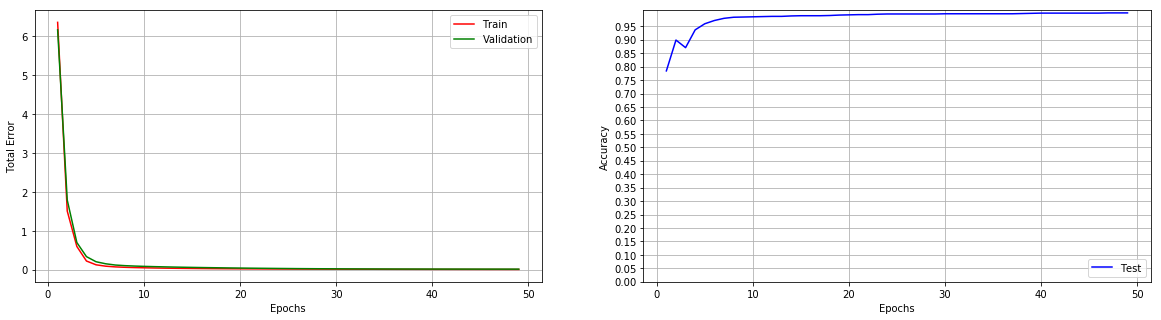

[1 1 0 ..., 0 0 0]
[1 1 0 ..., 0 0 0]
Number of False Prediction: 0


In [35]:
epoch_list = []
train_error_list = []
validation_error_list = []
test_accuracy_list = []
diff_index_list = []

with tf.Session() as sess:

    init = tf.global_variables_initializer()
    sess.run(init)

    total_batch = int(math.ceil(train['data'].shape[0]/float(batch_size)))
    print("Total batch: %d" % total_batch)

    for epoch in range(training_epochs):

        epoch_list.append(epoch)

        # Train Error Value
        train_error_value = sess.run(error, feed_dict={x: train['data'], y_target: train['labels']})
        train_error_list.append(train_error_value)
       
        validation_error_value = sess.run(error, feed_dict={x: validation['data'], y_target: validation['labels']})
        validation_error_list.append(validation_error_value)

        test_accuracy_value = sess.run(accuracy, feed_dict={x: test['data'], y_target: test['labels']})
        test_accuracy_list.append(test_accuracy_value) 

        print("Epoch: {0:2d}, Train Error: {1:0.5f}, Validation Error: {2:0.5f}, Test Accuracy: {3:0.5f}".format(
            epoch, train_error_value, validation_error_value, test_accuracy_value))

        for i in range(total_batch):
            batch_idx_begin = i * batch_size
            batch_idx_end = (i + 1) * batch_size + 1
            batch_features = train['data'][batch_idx_begin:batch_idx_end]
            batch_labels = train['labels'][batch_idx_begin:batch_idx_end]
            sess.run(optimizer, feed_dict={x: batch_features, y_target: batch_labels})

    # Draw Graph about Error Values & Accuracy Values
    draw_error_values_and_accuracy()

    # False Prediction Profile
    prediction = sess.run(tf.argmax(u_out, 1), feed_dict={x:test['data']})
    ground_truth = sess.run(tf.argmax(y_target, 1), feed_dict={y_target:test['labels']})

    print(prediction)
    print(ground_truth)

    for i in range(test['data'].shape[0]):
        if (prediction[i] != ground_truth[i]):
            diff_index_list.append(i)
          

    print("Number of False Prediction:", len(diff_index_list))

    draw_false_prediction()